In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

In [5]:
from utils import *
from data_handler import DataHandler
from feature_engineering import FeatureEngineering

In [6]:
data_handler = DataHandler()
feature_handler = FeatureEngineering()

In [7]:
# Due to 3 of the Stocks having different class, we have 503 classes instead of 500, those companies being (GOOG, GOOGL), (FOX, FOXA), (NWS, NWSA)
print("Total S&P 500 Companies: ", len(data_handler))

Total S&P 500 Companies:  503


In [8]:
snp = data_handler.get_snp()
display(snp)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [9]:
# The Following Stocks have multiple types, and they follow similar behavious

snp = snp.loc[~snp["Symbol"].isin(["GOOG", "FOX", "NWS"])]
tickers = snp["Symbol"].unique().tolist()#[:30]
print("Total Unique Tickers: ", len(tickers))

Total Unique Tickers:  30


# STORING AND PREPARING AVERAGE RETURN DATA FOR FUTURE

In [10]:
"""
For each Stock in our SNP500, we fetch the data and prepare the features that will be used to label 
the stock at each timestamp
"""


all_feature = []
for ticker in tqdm(tickers[:]): # iterating over all tickers from snp500
  try:
    # Fetch the data for a given stock
    df = data_handler.get_data(ticker)
    # Check if the datframe length is 0 we will not consider this stock for further experiment
    if len(df)==0:
      print(f"Skipping Ticker: {ticker} due to :: no data download")
      continue
    # fill in the stock dates between start date and end date
    # we fill the price from missing date with the last observed date values
    df = feature_handler.fill_missing_date(df.copy())
  except Exception as e:
    print(f"Skipping Ticker: {ticker} due to :: {e}")
    continue

  # create a column with the rate of price difference change between current price and price in 2 year future
  df_price_diff = feature_handler.get_price_diff(df.copy())
  # create columns with the mean and std of the rate of change over different window period (currently done for 7 days and 60 days)
  df_price_diff = feature_handler.add_rolling_average(df_price_diff.copy())

  # create columns that are then used to label stock at each point (taking into account the price diff and near window changes)
  feature = feature_handler.get_feature(df_price_diff)
  # add ticker name to the dataframe
  feature["Ticker"] = ticker
  all_feature.append(feature)

# concatenating all the dataframes into a single dataframe (TO BE REUSED OVER AND OVER)
all_feature = pd.concat(all_feature)

display(all_feature)


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\91973\Documents\GitHub\StockSynergy\feature_engineering.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method="ffill")
  3%|▎         | 1/30 [00:11<05:23, 11.14s/it]c:\Users\91973\Documents\GitHub\StockSynergy\feature_engineering.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method="ffill")
  7%|▋         | 2/30 [00:19<04:22,  9.37s/it]c:\Users\91973\Documents\GitHub\StockSynergy\feature_engineering.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method="ffill")
 10%|█         | 3/30 [00:28<04:05,  9.08s/it]c:\Users\91973\Documents\GitHub\StockSynergy\feature_engineering.py:24: FutureWarning: Series.fillna with 

,current_date,price,future_date,future_price,price_diff,mean_diff_7,std_diff_7,mean_diff_60,std_diff_60,cutoff_point_7_high,cutoff_point_7_low,cutoff_point_60_high,cutoff_point_60_low,movement,in_7,in_60,movement_type,Ticker
0,2015-01-01,NaN,2017-01-01,107.702866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,0,0,3,MMM
1,2015-01-02,92.933601,2017-01-02,107.702866,0.158923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,0,0,3,MMM
2,2015-01-03,92.933601,2017-01-03,107.389236,0.155548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,0,0,3,MMM
3,2015-01-04,92.933601,2017-01-04,107.552063,0.157300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,0,0,3,MMM
4,2015-01-05,90.837654,2017-01-05,107.184166,0.179953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,0,0,3,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,2022-05-24,142.631607,2024-05-24,128.229996,-0.100971,-0.057346,-0.057346,-0.174769,-0.174769,-0.130838,0.016146,-0.398745,0.049206,Down,0,0,3,AWK
2701,2022-05-25,141.113739,2024-05-25,128.229996,-0.091300,-0.065394,-0.065394,-0.172421,-0.172421,-0.149200,0.018412,-0.393388,0.048546,Down,0,0,3,AWK
2702,2022-05-26,142.967865,2024-05-26,128.229996,-0.103085,-0.074394,-0.074394,-0.170668,-0.170668,-0.169733,0.020946,-0.389387,0.048052,Down,0,0,3,AWK
2703,2022-05-27,145.792252,2024-05-27,128.229996,-0.120461,-0.085192,-0.085192,-0.169127,-0.169127,-0.194369,0.023986,-0.385872,0.047618,Down,0,0,3,AWK


In [11]:
save_data(all_feature, "data_snp500_movement_v2.csv")

In [12]:
len(all_feature)

81150

In [13]:
all_feature["Ticker"].nunique()

30

## Assigning Label to each movement of every stock (labels range from 1-12)

In [14]:
# Create a new dataframe with labels for each stock movement (there are in total 12 of these labels)
temp_all, df = get_data_label()
# Length of each stock sequence
lens = get_length_of_tickers(temp_all)
# storing the complete data in form of numpy array for easier operations
full_array = get_array(temp_all)
# Computing Siilarity Matrix between sequences of stocks
scores, all_tickers = get_similarity_score(df, full_array, lens)

c:\Users\91973\Documents\GitHub\StockSynergy\utils.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  temp: new dataframe with ticker, date and its label


Unique Lengths:  {2191}


30it [00:00, 61.33it/s]


In [15]:
save_data(scores, 'all_data_snp500_similarity_score_train.npy') # similarity score between each pair of stocks
save_data(all_tickers, "all_data_snp500_similarity_tickers_v2.pickle") # all tickers in order of there position in the similarity array 

# Clustering of Stocks based upon the identifies sequence Labels

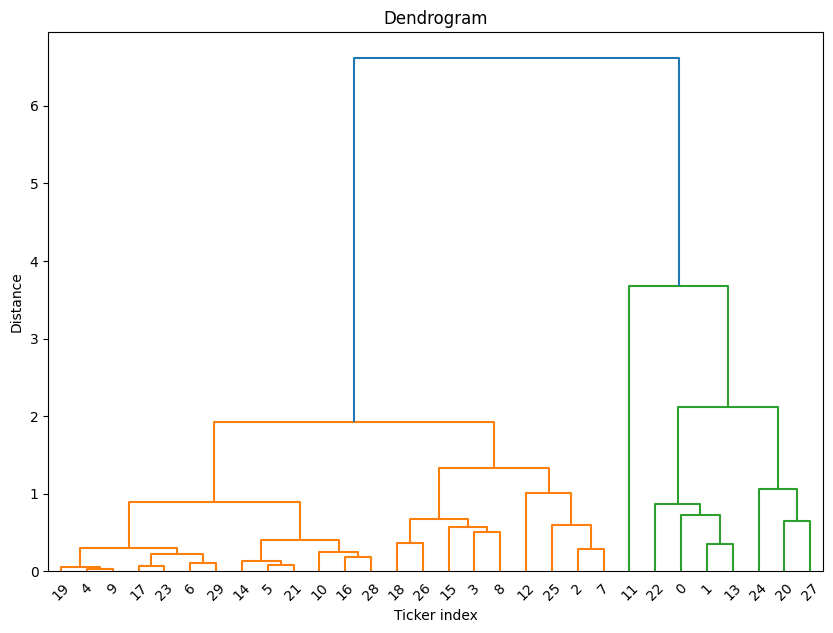

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

similarity_matrix = load_data("all_data_snp500_similarity_score_train.npy")
distance_matrix = 1 - similarity_matrix
linked = linkage(distance_matrix, 'ward')
plt.figure(figsize=(10, 7))
dendrogram = dendrogram(linked,
                            orientation='top',
                            labels=[f"{i}" for i in range(similarity_matrix.shape[0])],
                            distance_sort='ascending',
                            show_leaf_counts=True)

plt.title('Dendrogram')
plt.xlabel('Ticker index')
plt.ylabel('Distance')
plt.show()


# Clustering Stocks into multiple buckets
### Where stock in same bucket have minimal distance in terms of similarity

In [17]:
"""
Clustering Stocks into multiple buckets
Where stock in same bucket have minimal distance in terms of similarity
"""
cutoff_distance = 2
cluster_labels = fcluster(linked, cutoff_distance, criterion='distance')

print("Unique Cluster labels:", len(set(cluster_labels)))

ticker_name = load_data("all_data_snp500_similarity_tickers_v2.pickle")

df_cluster_label = {"Ticker": [], "Cluster": []}
for i in range(len(cluster_labels)):
  df_cluster_label["Ticker"].append(ticker_name[i])
  df_cluster_label["Cluster"].append(cluster_labels[i])

df_cluster_label = pd.DataFrame.from_dict(df_cluster_label)
display(df_cluster_label)
save_data(df_cluster_label, "stock_cluster_v2.csv")

Unique Cluster labels: 4


,Ticker,Cluster
0,MMM,2
1,AOS,2
2,ABT,1
3,ABBV,1
4,ACN,1
5,ADBE,1
6,AMD,1
7,AES,1
8,AFL,1
9,A,1


## Begining the Evaluation Phase
* Unlike the data used for clustering which was prior 1st Jan 2021, we will be evaluating on the next 6 months data from 1st Jan 2021

In [18]:
# Create a new dataframe with labels for each stock movement (there are in total 12 of these labels)
temp_all, df = get_data_label(lab_idx=label_index_eval, start_date=datetime(2015, 1, 1), end_date=datetime(2024, 12, 1))
# Length of each stock sequence
temp_all = temp_all.loc[(temp_all["current_date"]>datetime(2021, 1, 1)) & (temp_all["current_date"]<datetime(2021, 7, 1))]
df = df.loc[(df["current_date"]>datetime(2021, 1, 1)) & (df["current_date"]<datetime(2021, 7, 1))]
lens = get_length_of_tickers(temp_all)
# storing the complete data in form of numpy array for easier operations
full_array = get_array(temp_all)
# Computing Siilarity Matrix between sequences of stocks
scores, all_tickers = get_similarity_score(df, full_array, lens)

c:\Users\91973\Documents\GitHub\StockSynergy\utils.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  temp: new dataframe with ticker, date and its label


Unique Lengths:  {180}


30it [00:00, 246.41it/s]


In [19]:
# create a dataframe of similar stocks that are derived from historical data
df_same_cluster_ticker = df_cluster_label.groupby("Cluster")["Ticker"].apply(list).reset_index()
display(df_same_cluster_ticker)

,Cluster,Ticker
0,1,"[ABT, ABBV, ACN, ADBE, AMD, AES, AFL, A, APD, ..."
1,2,"[MMM, AOS, ALB, AMCR]"
2,3,"[MO, AAL, AIG]"
3,4,[ABNB]


In [20]:
matching_percentage = []

# iterate over all tickers
for idx, row in tqdm(enumerate(df_same_cluster_ticker.itertuples())):
  tickers = row.Ticker

  # if certain cluster has one element we will return here one
  if len(tickers)==1:
    matching_percentage.append(1)
    continue

  temp = temp_all.loc[temp_all["Ticker"].isin(tickers)]
  temp = get_array(temp)
    
  # computing the similarity of one sequence against rest and then taking their mean
  # This serves as our assesment quality of each cluster
  similarity = np.zeros((len(tickers), len(tickers)))
  for i in range(0, temp.shape[0], lens):
    base = temp[i:i+lens]
    for j in range(0, temp.shape[0], lens):
      target = temp[j:j+lens]
      matches, total = 0, 0
      for k, l in zip(base, target):
        if k<0 or l<0:
          continue
        if k==l:
          matches += 1
        total += 1
      similarity[i//lens,j//lens] = matches/(total+1)
  # print(similarity)
  val = sum_except_diagonal(similarity)
  norm = len(tickers)**2 - len(tickers)
  matching_percentage.append(val/norm)


0it [00:00, ?it/s]

4it [00:00, 25.23it/s]


In [21]:
df_same_cluster_ticker["Average Percentage Match"] =  matching_percentage
df_same_cluster_ticker["len"] =  df_same_cluster_ticker["Ticker"].apply(lambda x: len(x))
display(df_same_cluster_ticker)

,Cluster,Ticker,Average Percentage Match,len
0,1,"[ABT, ABBV, ACN, ADBE, AMD, AES, AFL, A, APD, ...",0.346201,22
1,2,"[MMM, AOS, ALB, AMCR]",0.298343,4
2,3,"[MO, AAL, AIG]",0.289134,3
3,4,[ABNB],1.000000,1


In [22]:
df_same_cluster_ticker["weighted match"] =  df_same_cluster_ticker["Average Percentage Match"] *  df_same_cluster_ticker["len"]

In [23]:
print("Average Percentage Match in Test Period: ", df_same_cluster_ticker["Average Percentage Match"].mean())
print("Weighted Average Percentage Match in Test Period: ", df_same_cluster_ticker["weighted match"].sum()/df_same_cluster_ticker["len"].sum())

Average Percentage Match in Test Period:  0.4834194350768936
Weighted Average Percentage Match in Test Period:  0.35590634043672714


In [24]:
data_handler = DataHandler()
snp = data_handler.get_snp()
snp_industry = snp.set_index("Symbol")["GICS Sub-Industry"].to_dict()
temp = (df_same_cluster_ticker.loc[df_same_cluster_ticker["len"]>1].sort_values(by=["Average Percentage Match"], ascending=False)[["Cluster",	"Ticker",	"Average Percentage Match",	"len"]])
industry_counter = []
for row in temp.itertuples():
  tickers = row.Ticker
  counter = {}
  for item in tickers:
    counter[snp_industry[item]] = counter.get(snp_industry[item], 0) + 1
  industry_counter.append(counter)
temp["Sub-Industry Counter"] = industry_counter
temp["Different Sub-Industries"] = temp["Sub-Industry Counter"].apply(lambda x: len(x))

In [25]:
save_data(temp, 'clustered_stocks_final.csv')

In [26]:
# Plotting Sample 
for i, row in enumerate(temp.itertuples()):
  cluster_ticker = row.Ticker
  tt = df.loc[df["Ticker"].isin(cluster_ticker)]
  fig = px.line(tt, x='current_date', y='price_diff', color='Ticker', title='Rate Of Change')
  fig.show()

  if i==9:
    break